In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import cvxpy as cp 
import json 

In [17]:
h = 0.5 # deltaT
g = 9.807
# m = 10.
Fmax = 854e3
Fmin = 0
p0 = np.array([50,50,1000]) #np.matrix('50 ;50; 100')
# v0 = np.array([-10,0,-10])  #np.matrix('-10; 0; -10')
v0 = np.array([-2,-5,-120])
alpha = 0.5 # glide slope angle
thetap = np.pi/4

Isp = 282
gamma = 1/(Isp*g) # fuel usage coefficient

mdry = 22.2e3 # dry mass in kg
mwet = mdry + 20e3 # wet mass in kg

K = 60

z0 = np.array([np.log(mwet - gamma*Fmax*h*i) for i in range(K+1)])
z1 = np.array([np.log(mwet - gamma*Fmin*h*i) for i in range(K+1)])
# print(z0)
# print(z1)

mumin = Fmin * np.exp(-z0)
mumax = Fmax * np.exp(-z0)

In [18]:
v = cp.Variable((3,K+1))
p = cp.Variable((3,K+1))
# p0 = cp.Variable(3)
# v0 = cp.Variable(3)
# f = cp.Variable((3,K))
# sig = cp.Variable(K) # slack variable
u = cp.Variable((3,K))
z = cp.Variable(K+1)
xi = cp.Variable(K)

# initial conditions
con = []
# con += [v[:,0] == v0.reshape((3,))]
con += [v[:,0] == v0]
con += [p[:,0] == p0]

# landing conditions
con += [v[:,-1] == np.zeros(3)]
con += [p[:,-1] == np.zeros(3)]

# vehicle dynamics and kinematicss
con += [v[:,i+1] == v[:,i] + u[:,i]*h - h*g*np.array([0,0,1]) for i in range(K)]
con += [p[:,i+1] == p[:,i] + (h/2)*(v[:,i]+v[:,i+1]) for i in range(K)]

# glide-slope constraint
con += [p[2,i] >= alpha*cp.norm(p[0:2,i]) for i in range(K+1)]

# mass flow rate and thrust constraints
con += [z[i+1] == z[i] - h*gamma*xi[i] for i in range(K)]
con += [mumin[i] * (1 - (z[i] - z0[i]) + 0.5*cp.square(z[i] - z0[i])) <= xi[i] for i in range(K)]
con += [mumax[i] * (1 - (z[i] - z0[i])) >= xi[i] for i in range(K)]
con += [z0[i] <= z[i] for i in range(K+1)]
con += [z[i] <= z1[i] for i in range(K+1)]

# pointing constraint
con += [cp.norm(u[:,i]) <= xi[i] for i in range(K)]
con += [u[2,i] >= xi[i]*np.cos(thetap) for i in range(K)]

# spacecraft mass limits
con += [cp.log(mdry) <= z[-1]]
con += [z[0] == cp.log(mwet)]

obj = cp.sum(xi)

In [19]:
prob = cp.Problem(cp.Minimize(obj), con)
prob.solve()

m = np.exp(z.value)[:-1]
print(m.shape)
f = m * u.value
funit = 100*(f/ np.linalg.norm(f, 2, 0))
print(f.shape)

(60,)
(3, 60)


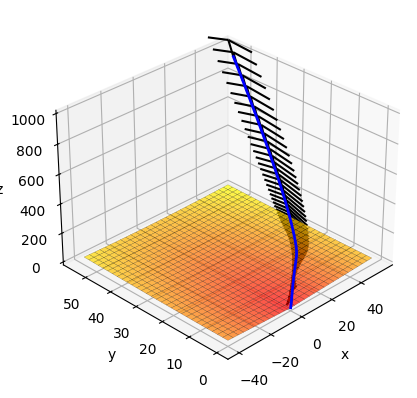

In [20]:
fig = plt.figure()
# ax = fig.gca(projection="3d")
ax = fig.add_subplot(projection="3d")

X = np.linspace(-40, 55, num=30)
Y = np.linspace(0, 55, num=30)
X, Y = np.meshgrid(X, Y)
Z = alpha*np.sqrt(X**2+Y**2)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.autumn, linewidth=0.1, alpha = 0.7, edgecolors="k")
ax = plt.gca()
ax.view_init(azim=225)
#Have your solution be stored in p
ax.plot(xs=p.value[0,:],ys=p.value[1,:],zs=p.value[2,:], c='b', lw=2, zorder = 5)
ax.quiver(p.value[0,:-1],p.value[1,:-1],p.value[2,:-1], 
         funit[0,:], funit[1,:], funit[2,:], zorder=5, color="black")

ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
# ax.axis('equal')
plt.show()

In [21]:
# K = 35
# while True: 
#     v = cp.Variable((3,K+1))
#     p = cp.Variable((3,K+1))
#     f = cp.Variable((3,K))

#     con = []
#     con += [v[:,0] == v0.reshape((3,))]
#     con += [p[:,0] == p0]
#     con += [v[:,i+1] == v[:,i] + (h/m)*f[:,i] -h*g*np.array([0,0,1]) for i in range(K)]
#     con += [p[:,i+1] == p[:,i] + (h/2)*(v[:,i]+v[:,i+1]) for i in range(K)]
#     con += [cp.norm(f[:,i]) <= Fmax for i in range(K)]
#     con += [p[2,i] >= alpha*cp.norm(p[0:2,i]) for i in range(K+1)]
#     con += [v[:,-1] == np.zeros(3)]
#     con += [p[:,-1] == np.zeros(3)]

#     obj = gamma * cp.sum([cp.norm(f[:,i]) for i in range(K)])
#     prob = cp.Problem(cp.Minimize(obj), con)
#     prob.solve()
    
#     if prob.status == 'optimal':
#         print("optimizaiton at K = ", K, "is successful")
#         K -= 1 
#     else:
#         print("optimizaiton at K = ", K, "failed")
#         break
        

In [22]:
# K += 1
# v = cp.Variable((3,K+1))
# p = cp.Variable((3,K+1))
# f = cp.Variable((3,K))

# con = []
# con += [v[:,0] == v0.reshape((3,))]
# con += [p[:,0] == p0]
# con += [v[:,i+1] == v[:,i] + (h/m)*f[:,i] -h*g*np.array([0,0,1]) for i in range(K)]
# con += [p[:,i+1] == p[:,i] + (h/2)*(v[:,i]+v[:,i+1]) for i in range(K)]
# con += [cp.norm(f[:,i]) <= Fmax for i in range(K)]
# con += [p[2,i] >= alpha*cp.norm(p[0:2,i]) for i in range(K+1)]
# con += [v[:,-1] == np.zeros(3)]
# con += [p[:,-1] == np.zeros(3)]

# obj = gamma * cp.sum([cp.norm(f[:,i]) for i in range(K)])
# prob = cp.Problem(cp.Minimize(obj), con)
# prob.solve()


In [23]:
# # use the following code to plot your trajectories
# # and the glide cone (don't modify)
# # -------------------------------------------------------
# fig = plt.figure()
# # ax = fig.gca(projection="3d")
# ax = fig.add_subplot(projection="3d")

# X = np.linspace(-40, 55, num=30)
# Y = np.linspace(0, 55, num=30)
# X, Y = np.meshgrid(X, Y)
# Z = alpha*np.sqrt(X**2+Y**2)
# ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.autumn, linewidth=0.1, alpha = 0.7, edgecolors="k")
# ax = plt.gca();
# ax.view_init(azim=225)
# #Have your solution be stored in p
# ax.plot(xs=p.value[0,:],ys=p.value[1,:],zs=p.value[2,:], c='b', lw=2, zorder = 5)
# ax.quiver(p.value[0,:-1],p.value[1,:-1],p.value[2,:-1], 
#          f.value[0,:], f.value[1,:], f.value[2,:], zorder=5, color="black")

# ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
# plt.show()

In [24]:
def skw(a):
    return np.array([[0, -a[2], a[1]],
                     [a[2], 0, -a[0]],
                     [-a[1], a[0], 0]])

def track_target(r_rtn, t, x_d=np.array([1, 0, 0]), r_target=np.zeros((3,1))):
    """
    Analytical formulation of quaternion to track the target (default: origin)
    Args:
        r_rtn : position history of the vehicle (3 x n_time)
        t     : time history of the vehicle  (n_time x 1)
        x_d      (optional) : Body frame line of sight unit vector (default : +x axis)  (1 x 3 array)
        r_target (optional) : pointing target in the inertial frame (default : origin) (3 x 1 array)
    Return:
        qw    : history of [q,w]  (7 x n_time)
        dw    : history of control (in delta-angular velocity) (7 x n_time-1)
    """

    if len(t) != r_rtn.shape[1]:
        raise ValueError("dimension of t and r_rtn is different. check the variable sizes.")
    
    n_time = len(t) - 1
    qw = np.zeros((7, n_time + 1))
    dw = np.zeros((3, n_time))
    dt = t[1] - t[0]
    
    
    for i in range(n_time + 1):
        r = r_target - r_rtn[:3, i].reshape((3,1))  # Adjust target location if necessary
        x_rho = r / np.linalg.norm(r)
        q_v = skw(x_d) @ x_rho / np.sqrt(2 * (1 + np.dot(x_d, x_rho)))
        q_0 = np.sqrt(2 * (1 + np.dot(x_d, x_rho))) / 2
        qw[0:4, i] = np.concatenate((np.array([q_0]), q_v)).flatten()
        
        # Check for singularity
        if np.any(np.isnan(q_v)):
            print(f'warning; singularity at timestep {i+1}/{n_time+1}')
            if i > 0:
                qw[0:4, i] = qw[0:4, i-1]
        
        if i > 0:
            # Compute the angular velocity
            q1 = qw[0:4, i-1]
            q2 = qw[0:4, i]
            w = 2/dt * np.array([
                q1[0]*q2[1] - q1[1]*q2[0] - q1[2]*q2[3] + q1[3]*q2[2],
                q1[0]*q2[2] + q1[1]*q2[3] - q1[2]*q2[0] - q1[3]*q2[1],
                q1[0]*q2[3] - q1[1]*q2[2] + q1[2]*q2[1] - q1[3]*q2[0]
            ])
            qw[4:7, i-1] = w
            
            if i > 1:
                dw[:, i-2] = qw[4:7, i-1] - qw[4:7, i-2]
    
    # Set the angular velocity at the end to the previous value
    qw[4:7, -1] = qw[4:7, -2]
    dw[:, -1] = np.zeros(3)
    
    return qw, dw

In [25]:
xyz = np.array(p.value[0:3, :])
rv = np.array(p.value)

t =  np.arange(np.shape(xyz)[1])
# print(t.shape)

In [26]:
qw, dw = track_target(xyz, t)

In [27]:
def q2rotmat(q):
    # Convert quaternion to rotation matrix
    q0, q1, q2, q3 = q
    return np.array([
        [1 - 2*q2**2 - 2*q3**2, 2*q1*q2 - 2*q0*q3,     2*q1*q3 + 2*q0*q2],
        [2*q1*q2 + 2*q0*q3,     1 - 2*q1**2 - 2*q3**2, 2*q2*q3 - 2*q0*q1],
        [2*q1*q3 - 2*q0*q2,     2*q2*q3 + 2*q0*q1,     1 - 2*q1**2 - 2*q2**2]
    ])
    

In [28]:
def plot_attitude_track(ax, rtn, qw, coneAngle, height=20):
    if rtn.shape[1] != qw.shape[1]:
        raise ValueError("rtn and qw have different length. Check the input variable")

    Nfreq = rtn.shape[1] // 20  # frequency of plotting axes
    print(Nfreq)
    N = rtn.shape[1]

    # Cone parameters
    radius = height * np.tan(coneAngle)
    # Meshgrid for polar coordinates
    r = np.linspace(0, radius, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    r, theta = np.meshgrid(r, theta)
    # Convert polar to cartesian coordinates
    coneX = r * np.cos(theta)
    coneY = r * np.sin(theta)
    coneZ = r * height / radius  # Scale Z based on height and radius
    coneX, coneY, coneZ = coneZ, coneX, coneY  # RTN trick
    
    for i in range(N):
        if i % Nfreq == 0 or i == N-1:
            R_i = q2rotmat(qw[:4, i])
            ex, ey, ez = R_i @ np.array([height, 0, 0]), R_i @ np.array([0, height, 0]), R_i @ np.array([0, 0, height])

            # plot axis
            ax.plot3D([rtn[0, i], rtn[0, i] + ex[0]], [rtn[1, i], rtn[1, i] + ex[1]], [rtn[2, i], rtn[2, i] + ex[2]], '-r', linewidth=2)
            ax.plot3D([rtn[0, i], rtn[0, i] + ey[0]], [rtn[1, i], rtn[1, i] + ey[1]], [rtn[2, i], rtn[2, i] + ey[2]], '-g', linewidth=2)
            ax.plot3D([rtn[0, i], rtn[0, i] + ez[0]], [rtn[1, i], rtn[1, i] + ez[1]], [rtn[2, i], rtn[2, i] + ez[2]], '-b', linewidth=2)

            coneVertices = np.vstack([coneX.flatten(), coneY.flatten(), coneZ.flatten()])
            coneVertices = R_i @ coneVertices 
            coneVertices = coneVertices + rtn[:3, i].reshape(-1, 1)

            # Reshape and plot
            coneXRotated = coneVertices[0, :].reshape(coneX.shape)
            coneYRotated = coneVertices[1, :].reshape(coneY.shape)
            coneZRotated = coneVertices[2, :].reshape(coneZ.shape)
            
            ax.plot_surface(coneXRotated, coneYRotated, coneZRotated, color='red', alpha=0.05, linewidth=0, antialiased=False)

3


Text(0.5, 0.5, 'y')

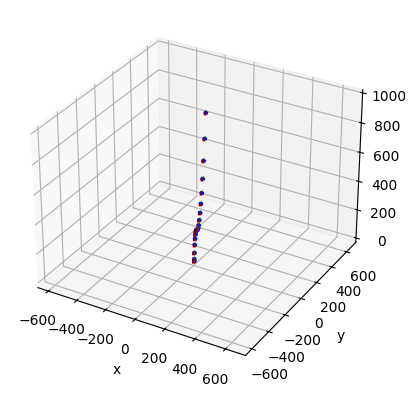

In [29]:
theta = np.pi/6
ax = plt.figure().add_subplot(projection='3d')
plot_attitude_track(ax, xyz, qw, theta, height=10)

# ax.quiver(p.value[0,:-1],p.value[1,:-1],p.value[2,:-1], 
#          f.value[0,:], f.value[1,:], f.value[2,:], zorder=5, color="black")
ax.axis("equal")
ax.set_xlabel("x")
ax.set_ylabel("y")

In [30]:
state = np.vstack([xyz, qw])

data = {
    "t" : t, 
    "state" : rv,
}

np.save("trajdata.npy", data)
